#### **SHAP**

https://slundberg.github.io/shap/notebooks/Census%20income%20classification%20with%20XGBoost.html<br>
https://github.com/slundberg/shap <br>
https://www.kaggle.com/dansbecker/shap-values

In [ ]:
!echo y | conda install -c conda-forge xgboost=0.90

In [ ]:
!echo y | conda install -c conda-forge shap

In [25]:
import xgboost
import shap
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
shap.initjs()

In [2]:
## модель, полученная в spark-scala-xgboost4j
modelFromScala = xgboost.XGBClassifier()
booster = xgboost.Booster()
booster.load_model("../../external/churn/model/xgb_native.json")
modelFromScala._Booster = booster

In [3]:
data = pd.read_csv("../../external/churn/data/shap/part-00000-3118b175-2bcb-4ea8-9c6c-5fc77969dbad-c000.csv", sep="\t")
data = data[data.target_userIgnr.isna() == False]

In [4]:
data.shape

(911370, 143)

In [5]:
target = "target_userIgnr"
exclude = "current_date,useID1,closest_auditDate,interval_befor,useID2,ratio_after,sum_showCont_after,sum_igndCont_after,interval_after,userId,useID,target_userLost".split(",") + [target]
main_cols = [c for c in data.columns if not c in exclude]

In [6]:
len(main_cols)

130

In [7]:
# print("\n".join(main_cols))

In [8]:
modelFromScala.feature_names = main_cols

In [20]:
predict = data[["current_date", "useID1", target]].copy()
predict["score"] = modelFromScala.predict_proba(data[main_cols])[:,1]

In [21]:
predict.head()

,current_date,useID1,target_userIgnr,score
2,2018-02-28,157824,0.0,0.633555
3,2018-02-28,176694,0.0,0.627825
5,2018-02-28,215112,0.0,0.240402
6,2018-02-28,356571,1.0,0.564360
8,2018-02-28,548673,0.0,0.569414


In [11]:
predictFromSpark = pd.read_csv("../../external/churn/data/score_train/part-00000-f7762da6-62ed-4168-a3f5-eb8278bbc611-c000.csv", sep="\t")

In [22]:
compare = predictFromSpark.merge(predict, how="inner", on=["current_date", "useID1"])

In [31]:
compare.shape

(911370, 6)

In [35]:
compare[["score_x","score_y"]].corr()

,score_x,score_y
score_x,1.000000,0.999629
score_y,0.999629,1.000000


In [27]:
compare1 = compare[(compare.score_x != compare.score_y)].copy()

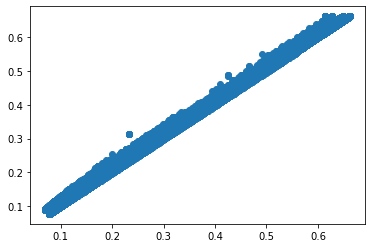

In [26]:
plt.scatter(compare.score_x, compare.score_y)

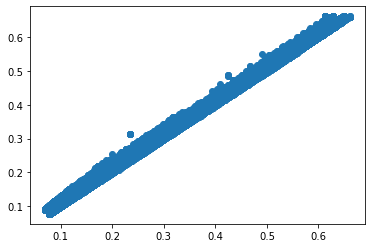

In [28]:
plt.scatter(compare1.score_x, compare1.score_y)

<br>**точность предикта отличается, интересно почему**

(-0.03, 0.03)

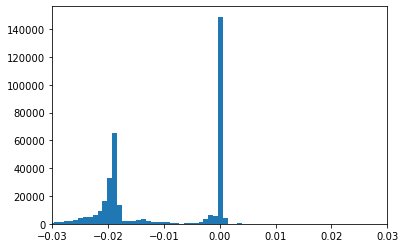

In [36]:
plt.hist(compare1.score_x-compare1.score_y, 100);
plt.xlim(-0.03,0.03)

In [ ]:
# TODO

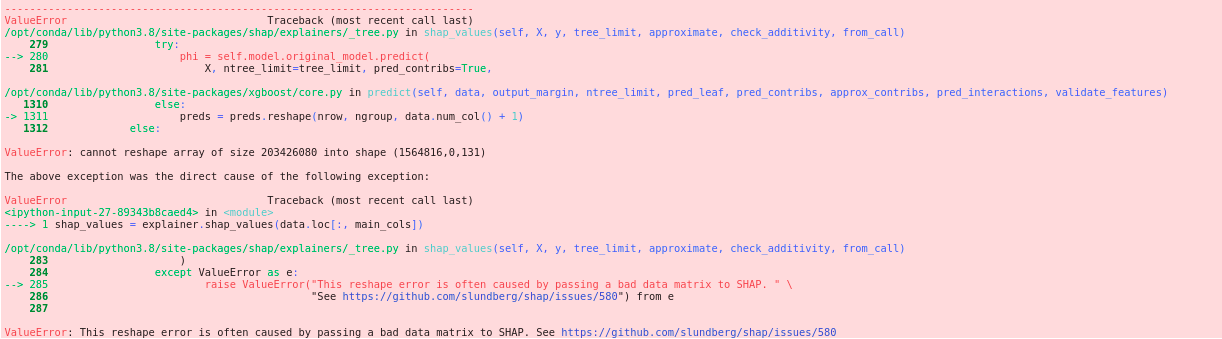

In [ ]:
explainer = shap.TreeExplainer(modelFromScala)

In [ ]:
shap_values = explainer.shap_values(data.loc[:, main_cols])